In [1]:
# STEP 1: Import package code
%matplotlib inline
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from plantcv import plantcv as pcv
import matplotlib
matplotlib.rcParams["figure.figsize"] = [10, 10]

In [2]:
# STEP 2: Set global variables
device = 0                                                      # Workflow step counter
debug = 'plot'                                                  # Plot debug images to the notebook
rgb_img = './IMG_5963.jpeg'                # Image filename
genotype = 'NF0001904'                                              # Plant genotype ID
outfile = str(genotype) + '_plantcv_results.txt'                # Output filename

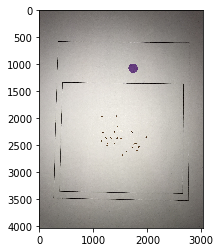

In [3]:
# STEP 3: Read RGB image and plot it to the notebook
# Inputs:
#    filename = name of image file
img, path, filename = pcv.readimage(rgb_img, debug)

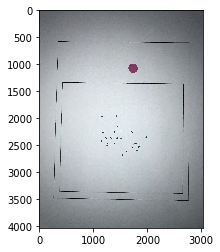

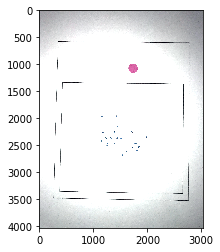

In [4]:
# Step 4: Normalize the white color so you can later
# compare color between images.
# Inputs:
# device = device number. Used to count steps in the workflow
# img = image object, RGB colorspace
# roi = region for white reference, if none uses the whole image,
# otherwise (x position, y position, box width, box height)

#white balance image based on white color card
device,img1=pcv.white_balance(device,img,'hist',debug,(0,200,200,200))
img=img1

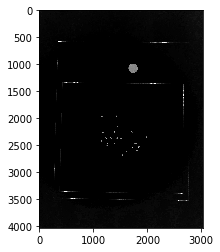

In [5]:
# STEP 5: Convert image from RGB colorspace to HSV colorspace
# Keep only the Saturation channel (grayscale)
# Inputs:
#    img     = image object, RGB colorspace
#    channel = color subchannel (h = hue, s = saturation, v = value/intensity/brightness)
#    device  = device number. Used to count steps in the workflow
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.
device, img_gray_sat = pcv.rgb2gray_hsv(img, 's', device, debug)

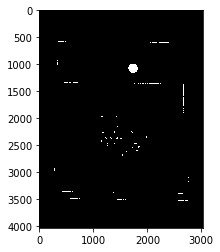

In [6]:
# STEP 6: Set a binary threshold on the Saturation channel image
# Inputs:
#    img         = img object, grayscale
#    threshold   = threshold value (0-255)
#    maxValue    = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#                  - If object is light then standard thresholding is done
#                  - If object is dark then inverse thresholding is done
#    device      = device number. Used to count steps in the pipeline
#    debug       = None, print, or plot. Print = save to file, Plot = print to screen.
device, img_binary = pcv.binary_threshold(img_gray_sat, 50, 255, 'light', device, debug)
#                                                       ^
#                                                       |
#                                                       adjust this value

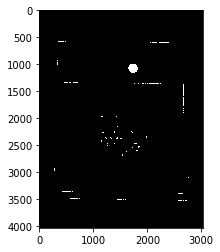

In [7]:
# STEP 7: Fill in small objects (speckles)
# Inputs:
#    img    = image object, grayscale. img will be returned after filling
#    mask   = image object, grayscale. This image will be used to identify contours
#    size   = minimum object area size in pixels (integer)
#    device = device number. Used to count steps in the pipeline
#    debug  = None, print, or plot. Print = save to file, Plot = print to screen.
mask = np.copy(img_binary)
device, fill_image = pcv.fill(img_binary, mask, 10, device, debug)
#                                               ^
#                                               |
#                                               adjust this value

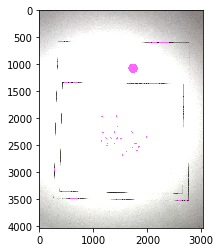

In [8]:
# STEP 8: Find objects (contours: black-white boundaries)
# Inputs:
#    img       = image that the objects will be overlayed
#    mask      = what is used for object detection
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
device, id_objects, obj_hierarchy = pcv.find_objects(img, fill_image, device, debug)

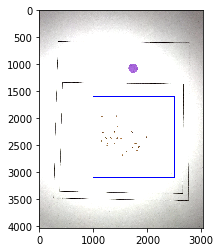

In [9]:
# STEP 9: Define region of interest (ROI)
# Inputs:
#    img       = img to overlay roi
#    roi       = default (None) or user input ROI image, object area should be white and background should be black,
#                has not been optimized for more than one ROI
#    roi_input = type of file roi_base is, either 'binary', 'rgb', or 'default' (no ROI inputted)
#    shape     = desired shape of final roi, either 'rectangle' or 'circle', if  user inputs rectangular roi but chooses
#                'circle' for shape then a circle is fitted around rectangular roi (and vice versa)
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
#    adjust    = either 'True' or 'False', if 'True' allows user to adjust ROI
#    x_adj     = adjust center along x axis
#    y_adj     = adjust center along y axis
#    w_adj     = adjust width
#    h_adj     = adjust height

pcv.params.debug='plot'
roi, roi_hierarchy = pcv.roi.rectangle(x=1000, y=1600, h=1500, w=1500, img=img)

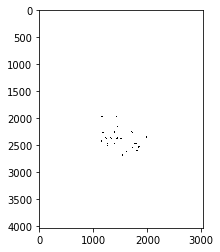

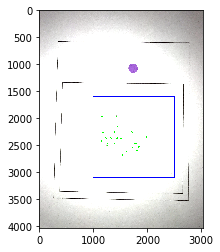

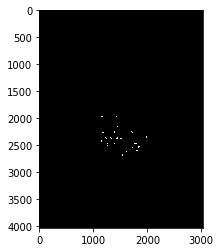

In [10]:
# STEP 10: Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction
#    device         = device number.  Used to count steps in the pipeline
#    debug          = None, print, or plot. Print = save to file, Plot = print to screen.
device, roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi, roi_hierarchy,
                                                                           id_objects, obj_hierarchy, device,
                                                                           debug)

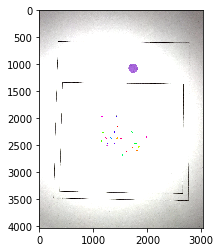

In [11]:
# STEP 11: Randomly color the individual seeds
img_copy = np.copy(img)
for i in range(0, len(roi_objects)):
    rand_color = pcv.color_palette(1)
    cv2.drawContours(img_copy, roi_objects, i, rand_color[0], -1, lineType=8, hierarchy=roi_obj_hierarchy)
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
# STEP 12: Measure the area of each seed
shape_header = [] # Store the table header
table = []        # Store the PlantCV measurements for each seed in a table
for i in range(0, len(roi_objects)):
    if roi_obj_hierarchy[0][i][3] == -1:  # Only continue if the object is an outermost contour
        
        # Object combine kept objects
        # Inputs:
        #    contours = object list
        #    device   = device number. Used to count steps in the pipeline
        #    debug    = None, print, or plot. Print = save to file, Plot = print to screen.
        device, obj, mask = pcv.object_composition(img, [roi_objects[i]], np.array([[roi_obj_hierarchy[0][i]]]), 
                                                   device, None)
        if obj is not None:
            # Measure the area and other shape properties of each seed
            # Inputs:
            #    img             = image object (most likely the original), color(RGB)
            #    imgname         = name of image
            #    obj             = single or grouped contour object
            #    device          = device number. Used to count steps in the pipeline
            #    debug           = None, print, or plot. Print = save to file, Plot = print to screen.
            #    filename        = False or image name. If defined print image
            device, shape_header, shape_data, shape_img = pcv.analyze_object(img, rgb_img, obj, mask, device, None)
            
            if shape_data is not None:
                table.append(shape_data)

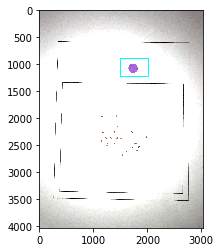

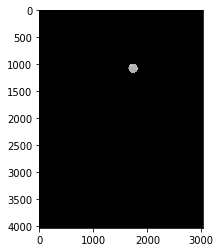

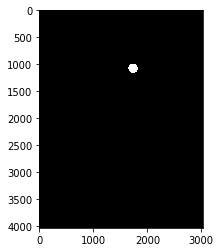

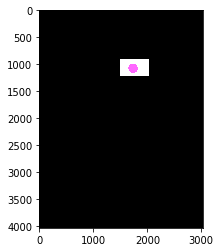

define_roi function will be depricated in the near future, please use the roi subpackage, which has the same functionality


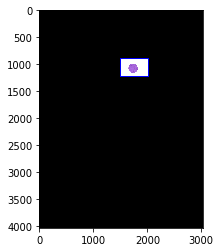

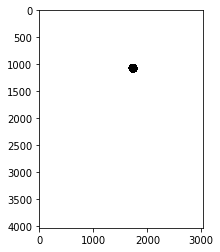

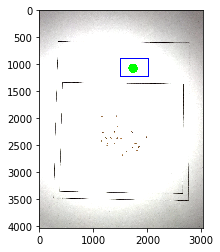

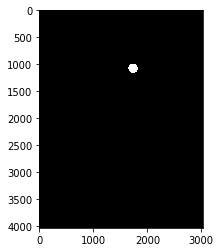

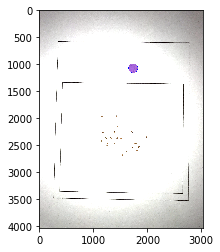

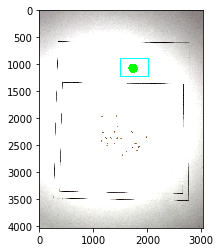

In [13]:
# STEP 13: Find the pixel area of the size standard
# Inputs:
#    img             = image object (most likely the original), color(RGB)
#    shape           = 'rectangle', 'circle', 'ellipse'
#    device          = device number. Used to count steps in the pipeline
#    debug           = None, print, or plot. Print = save to file, Plot = print to screen.
#    marker          = define or detect, if define it means you set an area, if detect it means you want to detect
#                      within an area
#    x_adj           = x position of shape, integer
#    y_adj           = y position of shape, integer
#    w_adj           = width
#    h_adj           = height
#    base            = background color 'white' is default
#    objcolor        = object color is 'dark' or 'light'
#    thresh_channel  = 'h', 's','v'
#    thresh          = integer value
#    filename        = name of file
device, marker_header, marker_data, analysis_images = pcv.report_size_marker_area(img, 'rectangle', device, debug,
                                                                                  'detect', 1500, 900, -1000, -2800,
                                                                                  'black', 'light', 's', 50)
# Adjust the marker region of interest values if necessary

In [14]:
# STEP 14: Save results to file
results = open(outfile, 'w')
results.write('\t'.join(map(str, ['genotype'] + shape_header + ['marker_area'])) + '\n')
for row in table:
    results.write('\t'.join(map(str, [genotype] + row + [marker_data[1]])) + '\n')
results.close()